In [1]:
# import library
import pandas as pd
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import seaborn as sns
import json
%matplotlib inline

In [2]:
# import data
dominicks_4128 = pd.read_csv("../data/store4128combined.csv",index_col=0)

In [3]:
dominicks_4128.head(5)

WeekStarting  dom_qty  mm_qty  trp_qty  dom_ad  mm_ad  trp_ad  dom_price  \
0   1990-06-14    18800   11269    11269       1      1       1       2.62   
1   1990-06-21    19493   10512    10512       1      1       1       2.49   
2   1990-06-28    13994   14028    14028       1      1       1       2.06   
3   1990-07-05    19658   10129    10129       1      1       1       2.57   
4   1990-07-12    19767   17728    17728       1      1       1       2.08   

   mm_price  trp_price  ...  trp_price_lag_3  dom_rev_lag_1  dom_rev_lag_2  \
0      2.51       2.51  ...              NaN            NaN            NaN   
1      1.91       1.91  ...              NaN       49256.00            NaN   
2      2.55       2.55  ...              NaN       48537.57       49256.00   
3      2.11       2.11  ...             2.51       28827.64       48537.57   
4      1.94       1.94  ...             1.91       50521.06       28827.64   

   dom_rev_lag_3  mm_rev_lag_1  mm_rev_lag_2  mm_rev_lag_3  trp_rev_lag_1  \
0            NaN           NaN           NaN           NaN            NaN   
1            NaN      28285.19           NaN           NaN       28285.19   
2            NaN      20077.92      28285.19           NaN       20077.92   
3       49256.00      35771.40      20077.92      28285.19       35771.40   
4       48537.57      21372.19      35771.40      20077.92       21372.19   

   trp_rev_lag_2  trp_rev_lag_3  
0            NaN            NaN  
1            NaN            NaN  
2       28285.19            NaN  
3       20077.92       28285.19  
4       35771.40       20077.92  

[5 rows x 40 columns]

In [4]:
df = {}
df["WeekDate"] = dominicks_4128["WeekStarting"].copy()
df["qty"] = dominicks_4128["dom_qty"].copy()
df["rev"] = dominicks_4128["dom_rev"].copy()
df["qty_lag"] = dominicks_4128["dom_qty_lag_1"].copy()
df["rev_lag"] = dominicks_4128["dom_rev_lag_1"].copy()

df = pd.DataFrame(df)

In [5]:
df.dropna(inplace=True)

# df.drop(columns="ad",inplace=True)

df["WeekDate"] = pd.to_datetime(df["WeekDate"])

df = df.set_index('WeekDate') # Set WeekStarting as index as per your info


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 1990-06-21 to 1992-10-01
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   qty      120 non-null    int64  
 1   rev      120 non-null    float64
 2   qty_lag  120 non-null    float64
 3   rev_lag  120 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 4.7 KB


In [7]:
print(df.head(5))

              qty       rev  qty_lag   rev_lag
WeekDate                                      
1990-06-21  19493  48537.57  18800.0  49256.00
1990-06-28  13994  28827.64  19493.0  48537.57
1990-07-05  19658  50521.06  13994.0  28827.64
1990-07-12  19767  41115.36  19658.0  50521.06
1990-07-19  19466  46913.06  19767.0  41115.36


In [8]:
# Step 2: Hyperparameter Tuning for VAR (Finding optimal 'p' lag order)
# We use the select_order() method on the VAR model.
# This method tests different lag orders and suggests the best one based on information criteria.

print("\nStarting VAR model order selection (hyperparameter tuning for 'p')...")

# Create a VAR model instance (not yet fitted) with your data
# VAR will use all numeric columns in the DataFrame by default
var_model_for_tuning = VAR(df)

# Select the optimal order (p)
# maxlags: The maximum number of lags to test
# verbose: Set to True to see the results for each tested lag order
# ic: The information criterion to use ('aic', 'bic', 'fpe', 'hqic')
# 'aic' is a common choice for balancing fit and complexity.

# Note: The `select_order` method returns a VARResultsWrapper containing the chosen order
var_order_selection = var_model_for_tuning.select_order(maxlags=10, trend='ctt')

print("\nOptimal VAR order selection results:")
# The .summary() method on the selection object shows the AIC/BIC for different lags
print(var_order_selection.summary())

# The best order is usually stored and can be accessed directly
optimal_lag_order = var_order_selection.aic
print(f"\nBest 'p' (lag order) based on AIC: {optimal_lag_order}")


Starting VAR model order selection (hyperparameter tuning for 'p')...

Optimal VAR order selection results:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        64.82       65.12   1.420e+28       64.94
1      -68.47*     -67.78*  1.834e-30*     -68.19*
2       -68.47      -67.39   1.839e-30      -68.03
3       -67.59      -66.12   4.451e-30      -66.99
4       -65.83      -63.97   2.605e-29      -65.07
5       -64.85      -62.59   7.047e-29      -63.93
6       -66.15      -63.50   1.950e-29      -65.07
7       -61.46      -58.42   2.159e-27      -60.23
8       -64.80      -61.36   7.888e-29      -63.41
9       -66.25      -62.42   1.932e-29      -64.69
10      -65.03      -60.81   6.829e-29      -63.32
--------------------------------------------------

Best 'p' (lag order) based on AIC: 1


C:\Users\preda\.conda\envs\azuredp100\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-THU will be used.
  self._init_dates(dates, freq)


In [14]:
 # Step 3: Saving Hyperparameters
# Convert optimal_lag_order from numpy.int64 (or similar) to a standard Python int
hyperparameters_to_save = {
    'optimal_lag_order': int(optimal_lag_order) # <--- FIX: Cast to standard Python int
}

# Define a filename for the JSON file
filename = 'var_hyperparameters.json'
with open(filename, 'w') as f:
    json.dump(hyperparameters_to_save, f, indent=4)

print(f"\nOptimal hyperparameters saved to '{filename}':")
print(json.dumps(hyperparameters_to_save, indent=4))


Optimal hyperparameters saved to 'var_hyperparameters.json':
{
    "optimal_lag_order": 1
}


In [17]:
# Step 4: Load Hyperparameters and Fit the VAR Model

# Load the optimal lag order from the saved file
loaded_hyperparameters = {}
try:
    with open('var_hyperparameters.json', 'r') as f:
        loaded_hyperparameters = json.load(f)
    loaded_optimal_lag_order = loaded_hyperparameters['optimal_lag_order']
    print(f"\nLoaded optimal lag order: {loaded_optimal_lag_order}")
except FileNotFoundError:
    print("\nError: var_hyperparameters.json not found. Using the 'optimal_lag_order' from the current session.")
    loaded_optimal_lag_order = optimal_lag_order # Fallback if file not found

# Split data into training and test sets (using df_for_var, the cleaned DataFrame)
train_size = int(len(df) * 0.7) # 70% for training
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

print(f"\nData split: Training set size = {len(train_data)}, Test set size = {len(test_data)}")

# Ensure training data is clean (no constant columns in the subset)
constant_cols_in_train = [col for col in train_data.columns if train_data[col].nunique() == 1]
if constant_cols_in_train:
    print(f"WARNING: Constant column(s) found in training data subset: {constant_cols_in_train}. Removing for fit.")
    train_data_cleaned_for_fit = train_data.drop(columns=constant_cols_in_train)
else:
    train_data_cleaned_for_fit = train_data.copy()

# Initialize and fit the VAR model with the loaded optimal lag order
print(f"\nFitting VAR({loaded_optimal_lag_order}) model on training data...")
try:
    final_var_model = VAR(train_data_cleaned_for_fit)
    final_var_model_fit = final_var_model.fit(loaded_optimal_lag_order, trend='c')

    print("\nFinal VAR Model Fit Summary (on training data):")
    print(final_var_model_fit.summary())

except Exception as e: # Catch any errors during fitting
    print(f"\nERROR: Model fitting failed: {e}")
    print("Cannot proceed with forecasting without a successfully fitted model.")
    final_var_model_fit = None # Set to None to prevent further errors


Loaded optimal lag order: 1

Data split: Training set size = 84, Test set size = 36

Fitting VAR(1) model on training data...

Final VAR Model Fit Summary (on training data):
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 27, Jun, 2025
Time:                     13:51:10
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -65.7272
Nobs:                     83.0000    HQIC:                  -66.0759
Log likelihood:           2300.78    FPE:                1.59281e-29
AIC:                     -66.3101    Det(Omega_mle):     1.26051e-29
--------------------------------------------------------------------
Results for equation qty
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const          12088.235210      2141.772915          

C:\Users\preda\.conda\envs\azuredp100\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-THU will be used.
  self._init_dates(dates, freq)


In [19]:
# Step 5: Perform Forecasting (ONLY if model fitted successfully)
if final_var_model_fit is not None:
    # Get the actual lag order (p) from the fitted model
    lag_order_p = final_var_model_fit.k_ar
    print(f"\nModel fitted with lag order (p): {lag_order_p}")

    # 1. Forecasting on the test set
    # The 'y' argument for forecast must be the last `lag_order_p` observations
    # from the data the model was trained on.
    last_train_obs_for_forecast = train_data_cleaned_for_fit.values[-lag_order_p:]

    print(f"\nForecasting {len(test_data)} steps for the test set...")
    forecast_test_set_values = final_var_model_fit.forecast(last_train_obs_for_forecast, steps=len(test_data))

    # Convert the NumPy array forecast back to a DataFrame with correct index and columns
    # Use test_data.index for the forecast's index, and df_for_var.columns for column names
    forecast_test_df = pd.DataFrame(forecast_test_set_values, index=test_data.index, columns=df.columns)
    print("\nVAR Forecast for Test Set (first 5 rows):")
    print(forecast_test_df.head())


    # 2. Forecasting truly future values (beyond your entire historical data)
    num_future_steps = 5 # How many weeks into the future to forecast

    print(f"\nForecasting {num_future_steps} truly future steps (beyond historical data)...")

    # The 'seed' for future forecast is the last `lag_order_p` observations of your ENTIRE historical dataset (`df_for_var`).
    last_full_data_obs_for_forecast = df.values[-lag_order_p:]

    # Generate future dates for the forecast
    last_known_date = df.index[-1]
    # Use the frequency of your DataFrame's index to generate future dates correctly
    future_dates = pd.date_range(start=last_known_date, periods=num_future_steps + 1, freq=df.index.freq)[1:]

    # Perform the future forecast
    future_forecast_values = final_var_model_fit.forecast(last_full_data_obs_for_forecast, steps=num_future_steps)

    # Convert to DataFrame with future dates and original column names
    future_forecast_df = pd.DataFrame(future_forecast_values, index=future_dates, columns=df.columns)

    print(f"\nVAR Future Forecast for the next {num_future_steps} weeks:")
    print(future_forecast_df)

else:
    print("\nForecasting skipped because the VAR model could not be fitted successfully in the previous step.")


Model fitted with lag order (p): 1

Forecasting 36 steps for the test set...

VAR Forecast for Test Set (first 5 rows):
                     qty           rev       qty_lag       rev_lag
WeekDate                                                          
1992-01-30  14945.347559  36227.099180  19523.000000  43536.290000
1992-02-06  14460.211933  31226.185123  14945.347559  36227.099180
1992-02-13  14905.584676  34429.531285  14460.211933  31226.185123
1992-02-20  14200.602723  32288.638721  14905.584676  34429.531285
1992-02-27  14522.920329  33127.465220  14200.602723  32288.638721

Forecasting 5 truly future steps (beyond historical data)...

VAR Future Forecast for the next 5 weeks:
                     qty           rev       qty_lag       rev_lag
1992-10-02  13229.527782  31004.573440   9164.000000  18144.720000
1992-10-03  13616.763199  32194.735131  13229.527782  31004.573440
1992-10-04  14424.802996  33182.455803  13616.763199  32194.735131
1992-10-05  14621.920781  33748.07307

In [20]:

print("\nForecast for Test Set:")
print(forecast_df.head()) # Show first few forecasted rows for the test period



Forecast for Test Set:
                     qty           rev       qty_lag       rev_lag
WeekDate                                                          
1992-01-30  14945.347559  36227.099180  19523.000000  43536.290000
1992-02-06  14460.211933  31226.185123  14945.347559  36227.099180
1992-02-13  14905.584676  34429.531285  14460.211933  31226.185123
1992-02-20  14200.602723  32288.638721  14905.584676  34429.531285
1992-02-27  14522.920329  33127.465220  14200.602723  32288.638721


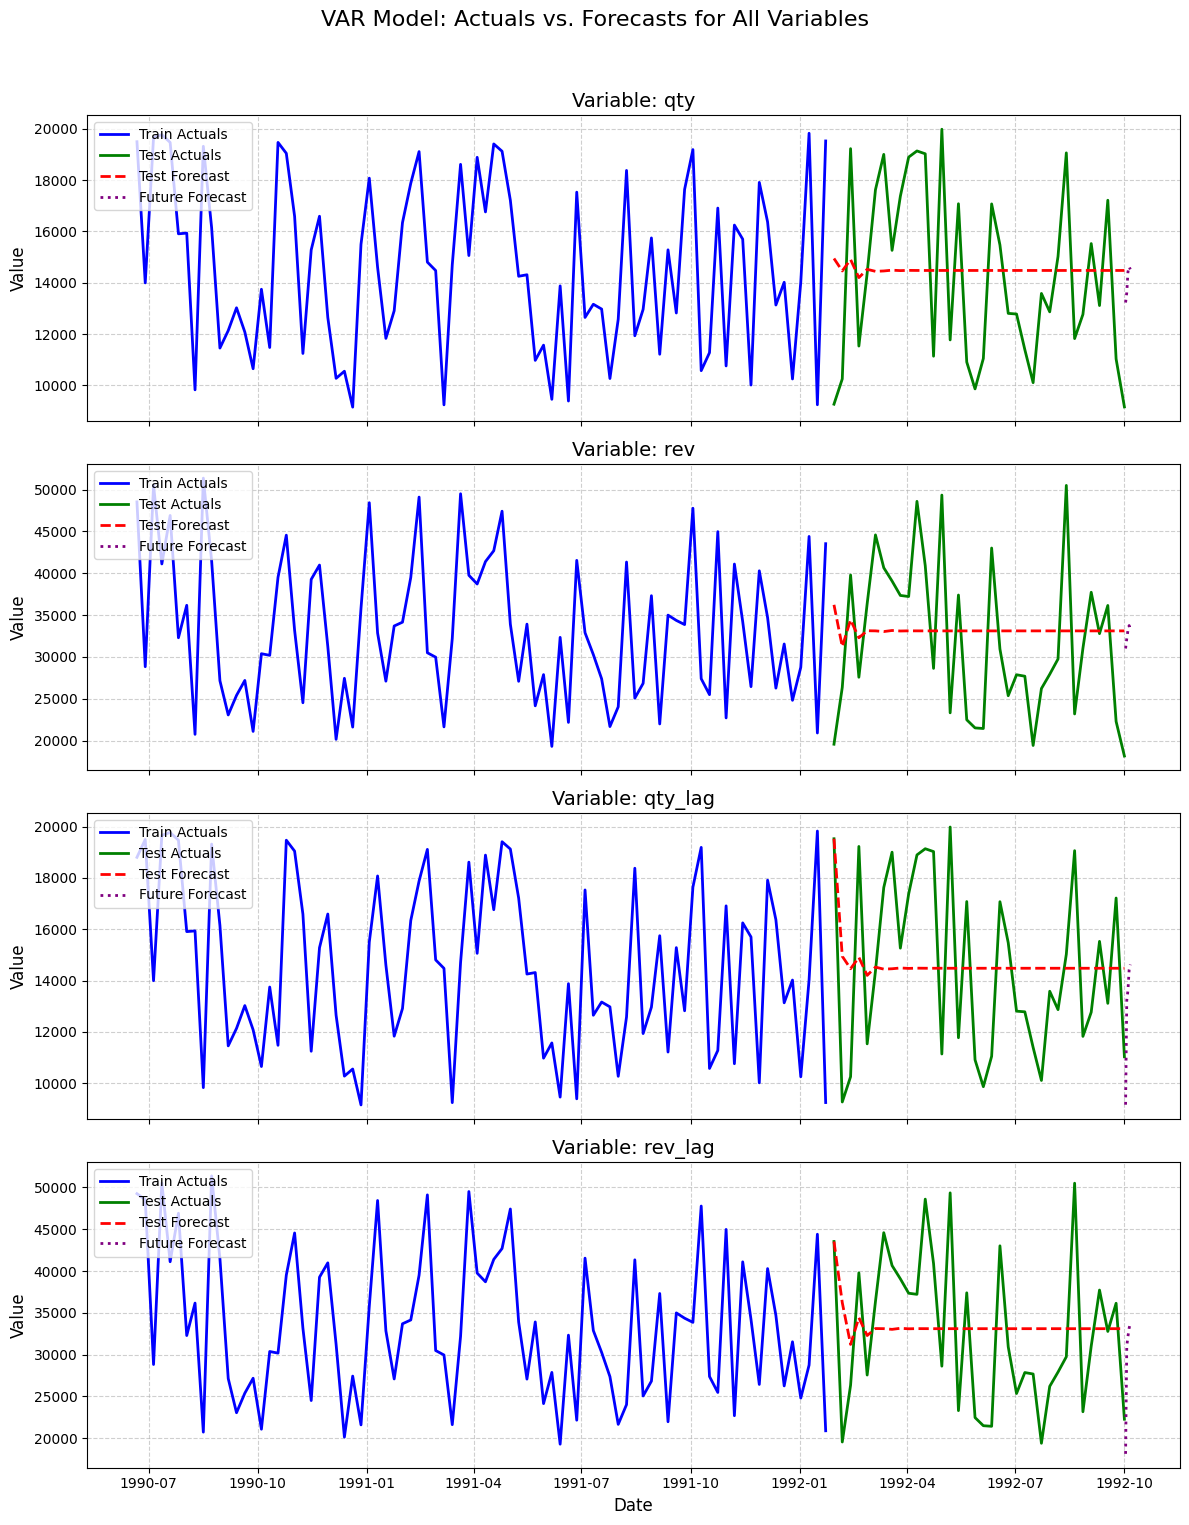

In [22]:

# Proceed with plotting only if the model fitting was successful
columns_to_plot = df.columns

# Determine the number of rows for subplots based on the number of variables
num_cols = len(columns_to_plot)

# Create a figure and a set of subplots
# sharex=True ensures all subplots share the same X-axis (time)
fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(12, 4 * num_cols), sharex=True)
fig.suptitle('VAR Model: Actuals vs. Forecasts for All Variables', fontsize=16)

# Loop through each column (variable) and create a subplot
for i, col in enumerate(columns_to_plot):
    ax = axes[i] # Get the current subplot axis

    # Plot training data (actuals)
    ax.plot(train_data_cleaned_for_fit.index, train_data_cleaned_for_fit[col],
            label='Train Actuals', color='blue', linewidth=2)

    # Plot test data (actuals)
    ax.plot(test_data.index, test_data[col],
            label='Test Actuals', color='green', linewidth=2)

    # Plot test set forecasts (predictions for the test period)
    ax.plot(forecast_test_df.index, forecast_test_df[col],
            label='Test Forecast', color='red', linestyle='--', linewidth=2)

    # Plot truly future forecasts (beyond historical data)
    ax.plot(future_forecast_df.index, future_forecast_df[col],
            label='Future Forecast', color='purple', linestyle=':', linewidth=2)

    # Set title and labels for the current subplot
    ax.set_title(f'Variable: {col}', fontsize=14)
    ax.set_ylabel('Value', fontsize=12)
    ax.legend(loc='upper left', fontsize=10) # Add legend to each subplot
    ax.grid(True, linestyle='--', alpha=0.6) # Add a grid for readability

# Set common X-axis label (only for the bottom subplot)
plt.xlabel('Date', fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent title overlap
plt.show() # Display the plots
